# Matrix Multiplication from Foundations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

As we go along through this version of Part II of the fast.ai Deep Learning course, we'll be recreating from scratch much of the source code found in both the [fastai](https://github.com/fastai/fastai) and [PyTorch](https://pytorch.org/docs/stable/index.html) libraries.

And we'll be doing so using only Jupyter Notebooks. In order to make this work, as we create new notebooks in each new lesson we'll need to be able to import functions and classes written in preceding notebooks. 

So let's first verify that we can do this:

In [2]:
from exports.nb_00 import *

We create a general method to use to test whether two variables contain identical values. Then we ascertain that we successfully imported from the notebook `nb_00.ipynp` that's in the `exports` folder.

This notebook contains one variable, `TEST`, which is defined as the string `"test"`.

In [3]:
#export

import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f'{cname}:\n{a}\n{b}'
    
def test_eq(a,b): test(a,b,operator.eq, '==')

In [4]:
test_eq(TEST,'test')

## Get the MNIST Dataset

We'll be using [MNIST](https://en.wikipedia.org/wiki/MNIST_database) in this notebook to demonstrate that our re-creations of parts of fastai and PyTorch are working like they're supposed to.

In [5]:
#export

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [6]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/ubuntu/.fastai/data/mnist.pkl.gz')

In [7]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [8]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [9]:
assert x_train.shape[0]==y_train.shape[0]==50000
test_eq(x_train.shape[1],28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [10]:
# Tell matplotlib to display images using a gray colormap
mpl.rcParams['image.cmap'] = 'gray'

In [11]:
img = x_train[0]

In [12]:
img.view(28,28).type()

'torch.FloatTensor'

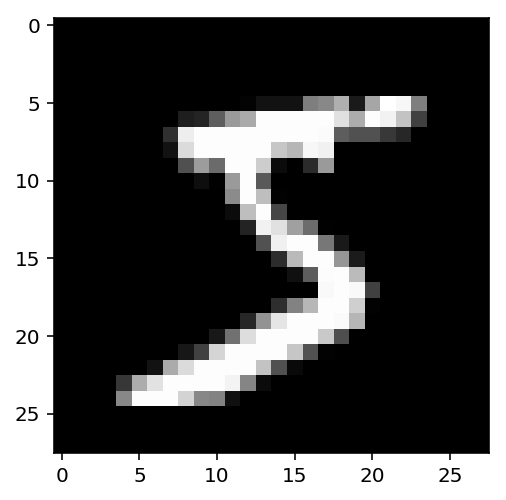

In [13]:
plt.imshow(img.view((28,28)));

## Initial Python Model

Shortly, we will create a neural network that will learn to classify the handwriting images of digits that are in the MNIST dataset.

Let's start by initiating the weights and biases of our network:

In [14]:
weights = torch.randn(784,10)/math.sqrt(784)

In [15]:
bias = torch.zeros(10)

## Matrix Multiplication

A big part of training our model will involve matrix multiplication. PyTorch automatically takes care of this for us. But since our goal here is to build up the code necessary to train neural networks from scratch, let's first see exactly how matrix multiplication works. 

Then we'll optimize our code to make it as fast as possible.

#### Matrix multiplication using for-loops

We're going to discover, step-by-step, how to implement a speed-optimized matrix multiplication method. Let's work our way there by starting off with the a relatively computationally inefficient, but perhaps more intuitive approach of using for-loops.

http://matrixmultiplication.xyz/ offers a great animation that visualizes each step of a matrix multiplication.

<img src= 'images/mat-mul.png' width='300'/>

In [16]:
def matmul(a,b):
    ar,ac = a.shape # shape is (num rows, num cols)
    br,bc = b.shape
    assert ac==br # num cols in left matrix must equal num rows in right matrix
    c = torch.zeros(ar,bc) # shape of the output product
    for i in range(ar): # for each row in left matrix
        for j in range(bc): # for each col in right matrix
            for k in range(ac): # for each col in left matrix, or for each row in right matrix (br)
                c[i,j] += a[i,k] * b[k,j]
    return c

In [17]:
m1 = x_valid[:5]
m2 = weights

In [18]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [19]:
%time t1=matmul(m1,m2)

CPU times: user 766 ms, sys: 0 ns, total: 766 ms
Wall time: 766 ms


When using our above for-loop method to compute the matrix product of our network's initial weights with the first five inputs from the validation set, we can see that it takes `766 ms`.

In [20]:
len(x_train)

50000

Given that our training set has not five, but fifty-thousand items, it's not difficult to imagine that training neural networks would be nigh impossible if the best way we had for performing matrix multiplication was using for-loops.

Thankfully, there are better ways!

#### Element-wise operations

The operators +, -, \*, /, <, >, == are usually element-wise.

Here are some examples:

In [21]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [22]:
a + b

tensor([12., 14.,  3.])

In [23]:
(a < b).float().mean()

tensor(0.6667)

In [24]:
m = tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Our final example will calculate the Frobenius, or $L^{2}$ norm, which is often used to provide regularization when training neural networks:

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

In [25]:
(m*m).sum().sqrt()

tensor(16.8819)

Indeed, it's often easier to understand a math formula by seeing how it's implemented in code.

#### Element-wise matmul

We can improve our previous matmul method by replacing the last for-loop with a set of element-wise operations.

In [26]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            # element-wise multiply each row in the left matrix 
            # by a given row from the right matrix, and sum
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [27]:
%timeit -n 10 _=matmul(m1,m2)

938 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
766*1000/938

816.6311300639659

This is about an eight hundred fold improvement over our pure Python implementation that used three for-loops.

Let's make sure that the element-wise modification we made to our matmul method still results in a similar-enough result.

In [28]:
#export

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a, b, near)

In [29]:
test_near(t1, matmul(m1,m2))

### Broadcasting

**Broadcasting** is a technique used for making the shapes of two tensors compatible, so that arithmetic operations may be performed between the two tensors.

We often speak of array operations being *vectorized*. Broadcasting is what makes this possible -- it enables looping to occur in C instead of in Python, and does not make needless copies of data. The actual term *broadcasting* was first [used by NumPy](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html).

As long as certain constraints are satisfied, the shape of smaller tensor is expanded to the size that would make it possible to efficiently perform an arithmetic operation between it and the larger tensor.

One additional benefit of broadcasting is that it lets the programmer specify the same behavior in fewer lines of code, as we will see below when we incorporate it as part of a revised matmul function.

Less code means a smaller chance that bugs will be inadvertently introduced during development.

Below are several different kinds of situations that exemplify how broadcasting is applied:

#### Broadcasting with a scalar

In [30]:
a

tensor([10.,  6., -4.])

In [31]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

Thanks to broadcasting, the above operation is completed as if each element in tensor `a` is being compared element-wise to `tensor([0, 0, 0])`. 

Additionally, memory is conserved because the only thing still stored in memory is `0`, as opposed to a tensor that contains one row with three elements. For each element-wise comparison, the C code pretends that this `0` value is the 0th, 1st, and finally 2nd indexed element of a tensor with one row, three elements.

In [32]:
a + 1

tensor([11.,  7., -3.])

In [33]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [34]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

Similarly to how we made a scalar behave as if it were a larger matrix full of identical values of that same scalar, we can also take a vector and broadcast its shape so that element-wise operations can be performed on it as if it had a higher dimension.

In [35]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [36]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [37]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [38]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [39]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Our vector `c` is indeed still stored in memory as a vector, but its elements have been added to the corresponding three elements in each row in the matrix `m`. 

More specifically, the rows of vector `c` have a *stride* of zero:

In [40]:
t = c.expand_as(m)

In [41]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [42]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [43]:
t.shape

torch.Size([3, 3])

In [44]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [45]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

#### Some indexing tips and tricks

To increase an array's dimension:

* Index with the special value **`None`**


In [46]:
c.shape, c[None,:].shape, c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

* Use `unsqueeze()`

In [47]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

Trailing `:`'s can always be skipped:

In [48]:
c[None].shape, c[None,:].shape

(torch.Size([1, 3]), torch.Size([1, 3]))

`'...'` means *"include all preceding dimensions"*:

In [49]:
c[...,None].shape, c[:,None].shape

(torch.Size([3, 1]), torch.Size([3, 1]))

In [50]:
c[...,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [51]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [52]:
m + c[...,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [53]:
c[None].expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [54]:
m + c[None]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [55]:
c[...,None], c[None]

(tensor([[10.],
         [20.],
         [30.]]), tensor([[10., 20., 30.]]))

As we saw just now, `c[...,None]` and `c[None]` have different shapes. The former is one column and the latter is one row. When each is broadcast out to the shape of `m`, `c[...,None]`'s one column are duplicated such that its rows are as long as those of `m`. And `c[None]`'s one row is duplicated, such that it now has as many columns as `m`.

#### Broadcasting Rules

When operating on two arrays, NumPy/PyTorch compares their shapes *element-wise*. 

It starts with **trailing dimensions**, and works its way forward. Two dimensions are deemed **compatible** when at least one of the following two conditions are met:

* They are equal.
* One of the dimensions is 1.

Note that arrays *do not* need to have the same number of dimensions. If, for example, you have a `(256,256,3)` shaped array of RGB color values and you want to scale each color/channel of an image by a different value, it is sufficient to just multiply the image by a 1-D array with three values.

If you line up the sizes of the trailing axes according to the broadcasting rules, you can observe that they are compatible:

```
Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3
```

NumPy documentation shows [several examples](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) of what dimensions can and can't be broadcast together.

For example, in 

```
A      (2d array):      2 x 1
B      (3d array):  8 x 4 x 3 
```
A and B cannot be broadcast together because the respective sizes of their second-to-last dimension don't match.

In [56]:
c[None,:]

tensor([[10., 20., 30.]])

In [57]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [58]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

As we can see above, `c[None,:]` can be broadcast to the shape of `c[:,None]` since the size of it's trailing dimension (3) is the same as the size of `c[:,None]`'s trailing dimension, even though the former's trailing dimension happens to be a row, while that of the latter happens to be a columns.

#### Matmul with broadcasting

We can further speed up our matrix multiplication method by taking advantage of broadcasting. We go row-by-row through the left-hand matrix, broadcasting each row of the left-hand matrix out to the size of the right-hand matrix, performing an element-wise multiplication between the two matrices, and then summing up this result across its rows. The resulting vector becomes one row in the final product `c`.

In [59]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        # c[i,j] = (a[i,:] * b[:,j]).sum() # previous approach
        c[i] = (a[i,:].unsqueeze(-1) * b).sum(dim=0)
    return c

In [60]:
%timeit -n 10 _=matmul(m1, m2)

258 µs ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
938/258

3.635658914728682

This is under four times faster than our previous best attempt above. Let's make sure the this latest matmul method still returns the correct answer:

In [61]:
test_near(t1, matmul(m1, m2))

Also, notice how we unsqueezed each row of `a` before then broadcasting it so that we could perform an element-wise multiplacation with `b`. Here's what unsqueeze does:

In [62]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [63]:
m[0,:].unsqueeze(-1)

tensor([[1.],
        [2.],
        [3.]])

In the example above unsqueeze takes a given row from `m` and turns it into one column, filling that column with a row for each element that was originally in the given row in `m`. The same thing was done for each row in the matrix `a` in our latest matmul method.

### Einstein Summation

[Einstein summation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html) offers a very concise description for combining products and sums. It is comma-separated string of subscript labels that can be used to describe, and then compute, a wide variety of multi-dimensional array operations. 

For example, the following notation to describes matrix multiplication:
```
'ij,jk'
```

Each letter refers to a dimension and each matrix is separated by a comma. The left-hand matrix has `i` rows and `j` columns. While the right-hand matrix has `j` rows (which we would expect to be the case for two matrices we will multiply together) and `k` columns.

In [64]:
def matmul(a,b): return torch.einsum('ij,jk', a,b)

In [73]:
%timeit -n 10 _=matmul(m1, m2)

40.3 µs ± 7.74 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
test_near(t1, matmul(m1,m2))

In [74]:
258/40.3

6.4019851116625315

Using einstein summation allows us to perform matmul six times faster than the time it took using broadcasting.

### Fastest: matrix multiplication using PyTorch

Below, we'll see that PyTorch's matmul operation is the fastest of all the available approaches. PyTorch goes one step further and kicks the matmul operation out to the basic linear algebra subprograms (BLAS) library tailored to Nvidia GPUs.

Known as cuBLAS, the library is a set of low-level subroutines created to run linear algebra operations as quickly as possible on the Nvidia chip hardware. Most chipmakers have their own BLAS libraries. For example, Intel's is known as the Intel Math Kernel Library, or MKL.

In [76]:
%timeit -n 10 t2 = m1@m2

10.9 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
40.3/10.9

3.697247706422018

In [78]:
766*1000 / 10.9

70275.22935779816

Sure enough, this takes just over one fourth as long as matmul with einstein summation did.

Much more extraordinarily, it is more than a whopping *70,000 times faster* than computing matrix multiplication with our initial pure Python attempt that used for-loops.

## Export

There were some methods written in this notebook that we'll want to use in the subsequent notebooks where we'll continue to build parts of fastai/PyTorch from scratch. 

Running the script below will store in a separate `.py` file all the functions in all code boxes in this notebook that contain an `#export` comment.

Importing this `.py` file in subsequent notebooks will allow us to access and use these functions.

In [79]:
!./notebook2script_my_reimplementation.py 01_matmul_my_reimplementation.ipynb

Converted 01_matmul_my_reimplementation.ipynb to nb_01.py
